In [1]:
import os
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

import re
import requests

import urllib.request, urllib.parse, urllib.error 
from bs4 import BeautifulSoup
# Data cleaning fuctions (to be used dynamically during data collection).

from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import explained_variance_score

import matplotlib.pyplot as plt
import seaborn as sns

stopwords = nltk.corpus.stopwords.words('english')
WNL = WordNetLemmatizer()


# TESTING EXAMPLE
example_category = 'Cognitivism' 
example_article = 'Distributed_cognition' # ['Knowledge', 'Symbol', 'John_Searle', 'Cognitivism_(psychology)', 'Memory', 'Artificial_life', 'Temperament', 'Education', 'Cognitive_psychology', 'Cognition', 'Embodied_cognition', 'Physiology', 'Computational_theory_of_mind', 'Noam_Chomsky', 'Roger_Penrose', 'Scientific_method', 'Reductionism', 'Rodney_Brooks', 'Information', 'Positivism', 'Stimulus_(physiology)', 'Representations', 'Learning', 'Mind', 'Behaviorism', 'Mathematician', 'Postmodern_philosophy', 'Psychology', "Ryle's_regress", 'Dynamicism', 'Homunculus_argument', 'Distributed_cognition', 'Philosopher', 'Environment_(systems)', 'Algorithm', 'Situated_cognition']

# 1. Load data, pick as subset by a part of speach.
POS = 'ADJ' # POS # ADJ NOUN VERB [craft more if needed in above code]
top_N = 50 # top_N # 30 / 50


load_path = os.getcwd() + '/data/top_words_categorised/top_words_'+POS+'_'+str(top_N)+'.csv'
#print(load_path)
df_topw_all_c = pd.read_csv(load_path)
df_topw_all_c.head()

,word,Positive,Behavioral genetics,Cultural,Quantitative,Developmental,Mathematical,Biological,Cross-cultural,Experimental,Comperative,Social,Neuropsychology,Cognitive,Evolutionary,Personality,Big Five,Cognitivism,Differential
0,social,2.41,2.10,5.05,2.13,4.27,1.96,1.12,2.36,2.92,1.15,9.45,0.88,3.37,5.51,3.29,4.37,1.83,3.51
1,many,1.81,3.61,1.79,2.65,3.43,2.89,2.27,1.63,2.84,2.03,3.22,2.29,2.90,4.04,2.68,2.33,1.59,2.10
2,human,2.45,3.39,1.84,1.20,3.91,2.60,2.53,1.05,2.11,1.63,2.84,2.07,2.99,6.52,2.76,1.52,2.13,1.57
3,different,1.12,2.55,2.31,1.57,3.41,1.92,1.91,1.42,2.13,1.10,3.20,1.91,3.40,3.20,2.68,2.41,1.34,2.68
4,new,1.57,2.02,1.31,2.11,2.57,1.35,1.19,0.99,2.41,2.55,2.51,1.25,2.03,2.36,1.99,1.68,1.54,1.14


In [6]:
# Data pre-cleaning 
def remove_url(text):
    return re.sub('https?://[A-Za-z0-9./]+','',text)
def html_strip_praser(text):
    return BeautifulSoup(text, "html.parser").get_text()
def html_strip_lxml(text):
    return BeautifulSoup(text, 'lxml').get_text()
def remove_special_characters(text, preserve):
    return re.sub("[^a-zA-Z{}]".format(preserve), " ", text)
def lowercase_text(text):
    return text.lower()
def strip_inner_spaces(text):
    return ' '.join([w.strip() for w in text.split()])
def remove_stop_words(text):
    return ' '.join([w for w in text.split() if not w in set(stopwords)])
def lemmatize_words(text, WNL):
    return ' '.join([WNL.lemmatize(word, pos='v') for word in text.split()])

def sent_cleaner(text):
    text = remove_url(text)
    #text = html_strip_lxml(text)
    text = remove_special_characters(text, preserve='-')
    text = lowercase_text(text)
    text = strip_inner_spaces(text)
    text = remove_stop_words(text)
    text = lemmatize_words(text, WNL)
    return text


In [8]:
# TEST SAMPLES
# ------------

base_path = os.getcwd() + '/data/'

# Iterate over csv_files [categories].
csv_files = [f for f in os.listdir(base_path) if not '.' in f and f not in ['word_counts', 'top_words_categorised'] and not f.startswith('test_wcl')]
print(csv_files)
text_words_d = {}
all_frames = {}
for f in csv_files:
    text_words_d[f] = dict()
    
    frames = []
    path = base_path+f+'/'
    file_names = [f for f in os.listdir(path) if f.endswith('csv') ]
    for fn in file_names:
        
    # Open each csv file.
        csv_file_path = path + fn 
        #print(csv_file_path)
        
        df = pd.read_csv(csv_file_path, encoding='utf-8')
        frames.append(df)
        
        text_words = ''.join([sent_cleaner(s) for s in df.sentence.to_list()]).split()
        text_words_d[f][fn.split('.')[0]] = text_words
        
        
    df_category_s = pd.concat(frames)
    all_frames[fn] = df_category_s
    print('{} ({} articles).'.format(f, len(df)))
print(len(all_frames))
all_categ_df = pd.concat(all_frames.values())
print(all_categ_df.head())
print(all_categ_df.shape)


# TESTING EXAMPLE
example_category = 'Cognitivism' 
example_article = 'Information'
te = text_words_d[example_category][example_article]
te_uniq = np.unique(te)

print('Testing example: article {} ({} words, {} unique).'.format(example_article, len(te), len(te_uniq)))



# FOR BROADER TESTING - All samples.
# n_samples = 0 
# for category_name, v in text_words_d.items():
#     for article_name, text in text_words_d[category_name].items():
#         #print(article_name, 'text of', len(text))
#         n_samples += 1
        
# print('{} articles represented as word collections'.format(n_samples))


['Cognitivism', 'Big_Five', 'Comperative', 'Biological', 'Evolutionary', 'Mathematical', 'Experimental', 'Social', 'Quantitative', 'Cross-cultural', 'Behavioral_genetics', 'Personality', 'Differential', 'Cognitive', 'Positive', 'Cultural', 'Neuropsychology', 'Developmental']
Cognitivism (163 articles).
Big_Five (180 articles).
Comperative (396 articles).
Biological (234 articles).
Evolutionary (10 articles).
Mathematical (34 articles).
Experimental (239 articles).
Social (203 articles).
Quantitative (676 articles).
Cross-cultural (131 articles).
Behavioral_genetics (147 articles).
Personality (26 articles).
Differential (249 articles).
Cognitive (180 articles).
Positive (13 articles).
Cultural (134 articles).
Neuropsychology (24 articles).
Developmental (249 articles).
17
                                            sentence      title       source  \
0  \n Knowledge is a familiarity, awareness, or u...  Knowledge  Cognitivism   
1  Knowledge can refer to a theoretical or practi...  Kno

In [9]:
text_words_d[example_category].keys()

dict_keys(['Knowledge', 'Symbol', 'John_Searle', 'Cognitivism_(psychology)', 'Memory', 'Artificial_life', 'Temperament', 'Education', 'Cognitive_psychology', 'Cognition', 'Embodied_cognition', 'Physiology', 'Computational_theory_of_mind', 'Noam_Chomsky', 'Roger_Penrose', 'Scientific_method', 'Reductionism', 'Rodney_Brooks', 'Information', 'Positivism', 'Stimulus_(physiology)', 'Representations', 'Learning', 'Mind', 'Behaviorism', 'Mathematician', 'Postmodern_philosophy', 'Psychology', "Ryle's_regress", 'Dynamicism', 'Homunculus_argument', 'Distributed_cognition', 'Philosopher', 'Environment_(systems)', 'Algorithm', 'Situated_cognition'])

Test example:
[('information', 10.207), ('mean', 1.68), ('knowledge', 1.68), ('word', 1.421), ('sign', 1.292)] ... N = 774


,word,variance
17,Cognitivism,0.146305
16,Cognitive,0.126728
15,Developmental,0.092808
14,Biological,0.090751
13,Mathematical,0.090515


<Figure size 432x288 with 0 Axes>

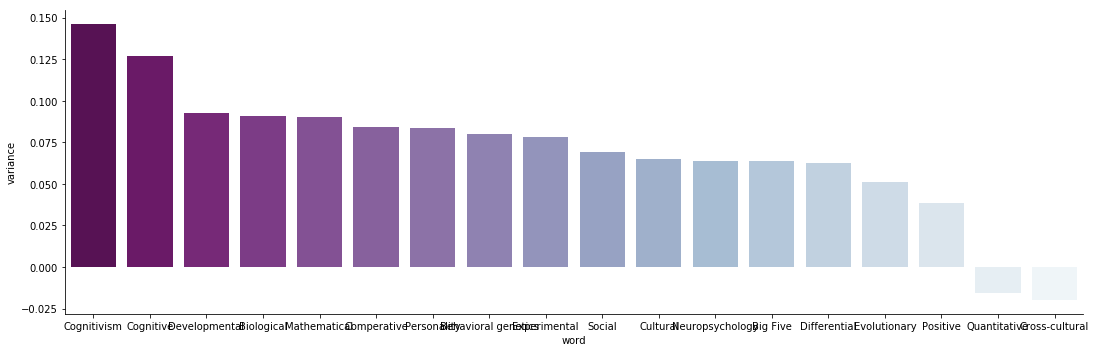

Closest fit - cognitivism by variance (true bid).


In [10]:

# NOT doing cleaning as double cleaned by a mistake.
# all_categ_df['s_clean'] = all_categ_df.sentence.apply(sent_cleaner)
all_categ_df.head()

# ONE HOT + NORM

def take_second(el):
    return el[1]

words_d = {}
for w in te:
    words_d[w] = 0
for w in te:
    words_d[w] += 1

#all_words_dict.items(),
words_s = sorted(words_d.items(), key=take_second)[::-1]
words_s = [(e[0], round(e[1]/len(words_s)*100,3) ) for e in words_s]

print('Test example:')
text_example = words_s
print(text_example[:5], '... N =',len(text_example))

# Data prep

word_perc_by_cat = {}
word_perc_by_cat2 = {}
for category in df_topw_all_c.columns[1:]:
    top_words_perc = df_topw_all_c.loc[:,['word', category]]
    top_words_perc = top_words_perc.T
    
    word_names = top_words_perc.iloc[0,:]
    word_values = top_words_perc.iloc[1,:]
    
    top_words_perc.columns = top_words_perc.iloc[0,:]
    
    top_words_perc = top_words_perc.iloc[1,:]
    word_perc_by_cat[category] = top_words_perc
    
    result = list(zip(word_names, word_values))
    word_perc_by_cat2[category] = result
    
for category in word_perc_by_cat.keys():
    s = word_perc_by_cat[category]
    #print(s)
    #print(len(s))
    
# word_perc_by_cat2['Positive']

results = []
if True:
    
    # Shape in results into category words:
    for category in word_perc_by_cat.keys():
        category_values = word_perc_by_cat[category]

        category_copy = list(zip(category_values.index, category_values))
        category_order = [e[0] for e in category_copy]

        # Equal shapes [0 input]
        result_d = {}
        for word in category_order:
            if word in dict(text_example).keys():
                result_d[word] = dict(text_example)[word]
            else:
                result_d[word] = 0.0

        result = dict(list(zip(result_d.keys(), result_d.values())))
        
        category_vals = []
        result_vals = []
        for k, v in result.items():
            category_val = category_values[k]
            category_vals.append(category_val)

            result_val = result[k]
            result_vals.append(result_val)
            
        #r2 = r2_score(category_vals, result_vals)
        #results.append((category, r2))
        
        variance = explained_variance_score(category_vals, result_vals)
        results.append((category, variance))
        
        
# Reversed order.
results  = sorted(results, key=take_second) # [::-1]

#pd.DataFrame(results).plot.bar()
df_vis = pd.DataFrame(results, columns=['word', 'variance'])

# Sorting
df_vis.sort_values(by='variance', inplace=True, ascending=False)
display(df_vis.head())
#tresh_df_vis = df_vis[df_vis.percent > 0.0]


figure = plt.figure()
g = sns.catplot(x="word", y="variance", kind="bar", palette="BuPu_r", margin_titles=True, data=df_vis);
g.fig.set_size_inches(20,5)
plt.show()

print('Closest fit - cognitivism by variance (true bid).')


,word,r2
17,Cognitivism,0.028302
16,Comperative,-0.026012
15,Cognitive,-0.045494
14,Biological,-0.049008
13,Cultural,-0.050883


<Figure size 432x288 with 0 Axes>

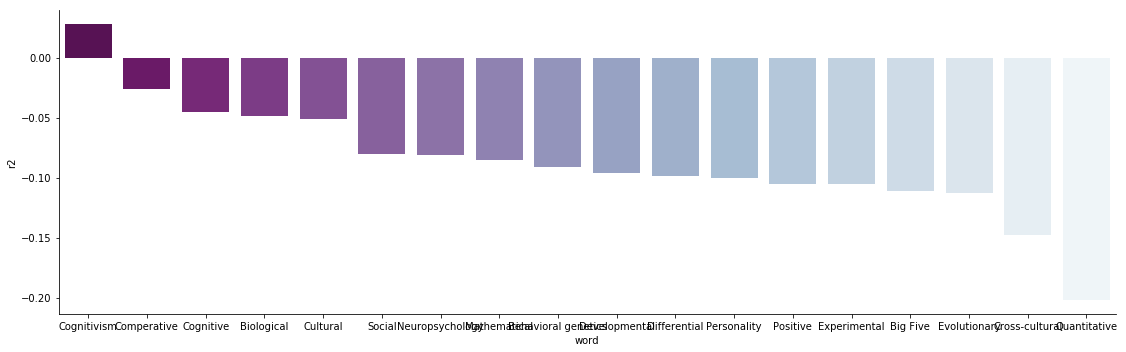

Closest fit - cognitivism by r2abs with treshond (true bid).
Top3 bids:


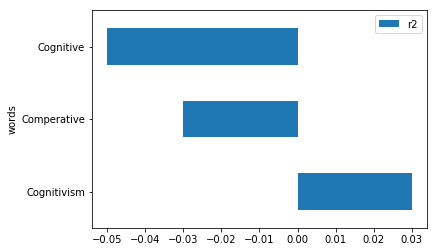

In [11]:
# Data prep

word_perc_by_cat = {}
word_perc_by_cat2 = {}
for category in df_topw_all_c.columns[1:]:
    top_words_perc = df_topw_all_c.loc[:,['word', category]]
    top_words_perc = top_words_perc.T
    
    word_names = top_words_perc.iloc[0,:]
    word_values = top_words_perc.iloc[1,:]
    
    top_words_perc.columns = top_words_perc.iloc[0,:]
    
    top_words_perc = top_words_perc.iloc[1,:]
    word_perc_by_cat[category] = top_words_perc
    
    result = list(zip(word_names, word_values))
    word_perc_by_cat2[category] = result
    
for category in word_perc_by_cat.keys():
    s = word_perc_by_cat[category]
    #print(s)
    #print(len(s))
    
# word_perc_by_cat2['Positive']

results = []
if True:
    
    # Shape in results into category words:
    for category in word_perc_by_cat.keys():
        category_values = word_perc_by_cat[category]

        category_copy = list(zip(category_values.index, category_values))
        category_order = [e[0] for e in category_copy]

        # Equal shapes [0 input]
        result_d = {}
        for word in category_order:
            if word in dict(text_example).keys():
                result_d[word] = dict(text_example)[word]
            else:
                result_d[word] = 0.0

        result = dict(list(zip(result_d.keys(), result_d.values())))
        
        category_vals = []
        result_vals = []
        for k, v in result.items():
            category_val = category_values[k]
            category_vals.append(category_val)

            result_val = result[k]
            result_vals.append(result_val)
            
        r2 = r2_score(category_vals, result_vals)
        
        results.append((category, r2))
        
# Reversed order.
results  = sorted(results, key=take_second) # [::-1]

#pd.DataFrame(results).plot.bar()
df_vis = pd.DataFrame(results, columns=['word', 'r2'])

# Sorting
df_vis.sort_values(by='r2', inplace=True, ascending=False)
display(df_vis.head())
#tresh_df_vis = df_vis[df_vis.percent > 0.0]

# 
figure = plt.figure()
g = sns.catplot(x="word", y="r2", kind="bar", palette="BuPu_r", margin_titles=True, data=df_vis);
g.fig.set_size_inches(20,5)
plt.show()

print('Closest fit - cognitivism by r2abs with treshond (true bid).')

top_3_classifications = df_vis.loc[:, 'word'].to_list()[:3]
print('Top3 bids:')
Top3_bids = [b for b in list(zip(top_3_classifications, round(df_vis.loc[:3, 'r2'],2)))]
df_t3 = pd.DataFrame(Top3_bids, columns=['words', 'r2'])
df_t3.sort_values(by='r2',inplace=True, ascending=False) 
df_t3.plot.barh(x='words')

In [ ]:
results = []
if True:
    # Shape in results into category words:
    for category in word_perc_by_cat.keys():
        category_values = word_perc_by_cat[category]

        category_copy = list(zip(category_values.index, category_values))
        category_order = [e[0] for e in category_copy]

        result_d = {}
        for word in category_order:
            if word in dict(text_example).keys():
                result_d[word] = dict(text_example)[word]
            else:
                result_d[word] = 0.0

        result = dict(list(zip(result_d.keys(), result_d.values())))
        
        category_vals = []
        result_vals = []
        for k, v in result.items():
            category_val = category_values[k]
            category_vals.append(category_val)

            result_val = result[k]
            result_vals.append(result_val)
            
        r2 = r2_score(category_vals, result_vals)
        mse = mean_squared_error(category_vals, result_vals)
        msle = mean_squared_log_error(category_vals, result_vals)
        mae = mean_absolute_error(category_vals, result_vals)
        variance = explained_variance_score(category_vals, result_vals)
        
        #diff_sum = sum(diff.values())
        results.append((category, r2, mse, msle, mae, variance))
        
# Reversed order
results  = sorted(results, key=take_second) # [::-1]

metric_names = ['r2','mse','msle','mae','variance']
metric_name = 'mse' 
tresh = 0.0 # None
#pd.DataFrame(results).plot.bar()
df_vis = pd.DataFrame(results, columns=['word', 'r2','mse','msle','mae','variance'])

display(df_vis)

if tresh:
    df_vis = df_vis[df_vis.r2 > tresh]
    tresh = None
    
display(df_vis.head())
for mn in metric_names:
    print('by', mn)
    figure = plt.figure()
    
    df_vis.sort_values(by=mn, inplace=True)
    g = sns.catplot(x="word", y=mn, kind="bar", palette='Accent', margin_titles=True, data=df_vis);
    g.fig.set_size_inches(20,5)
    plt.show()

In [ ]:
# As func
# For l of texts (cat iter, first key)
# Outside testing

# Grid 

# Coefs